# Finite Difference Integrator for Laplacian Heat Equation
When we discretize space and time, we can use a mesh to keep track of only some points and claim that it is a good enough representation of the true behavior. Calculations of derivatives require some creativity to ensure accuracy is high enough given a certain space resolution. One such class of methods is called finite difference which approximates partial derivatives based on Taylor expansions of functions around a certain point. This method is demonstrated on the Laplacian heat equation with insulating boundary conditions (we can constrain all heat to stay in the mesh by setting the boundaries to constants in time). The heat equation is given by $$\frac{\partial{u}}{\partial{t}} = \alpha\nabla^2{u}$$ such that $u$ denotes temperature and $\alpha$ is called the thermal diffusitivity which quantifies how easily a material changes temperature. 
### Finite Difference for $\frac{\partial{u}}{\partial{t}}$

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time

### Setup the initial "Temperature Snapshot" of our mesh to integrate

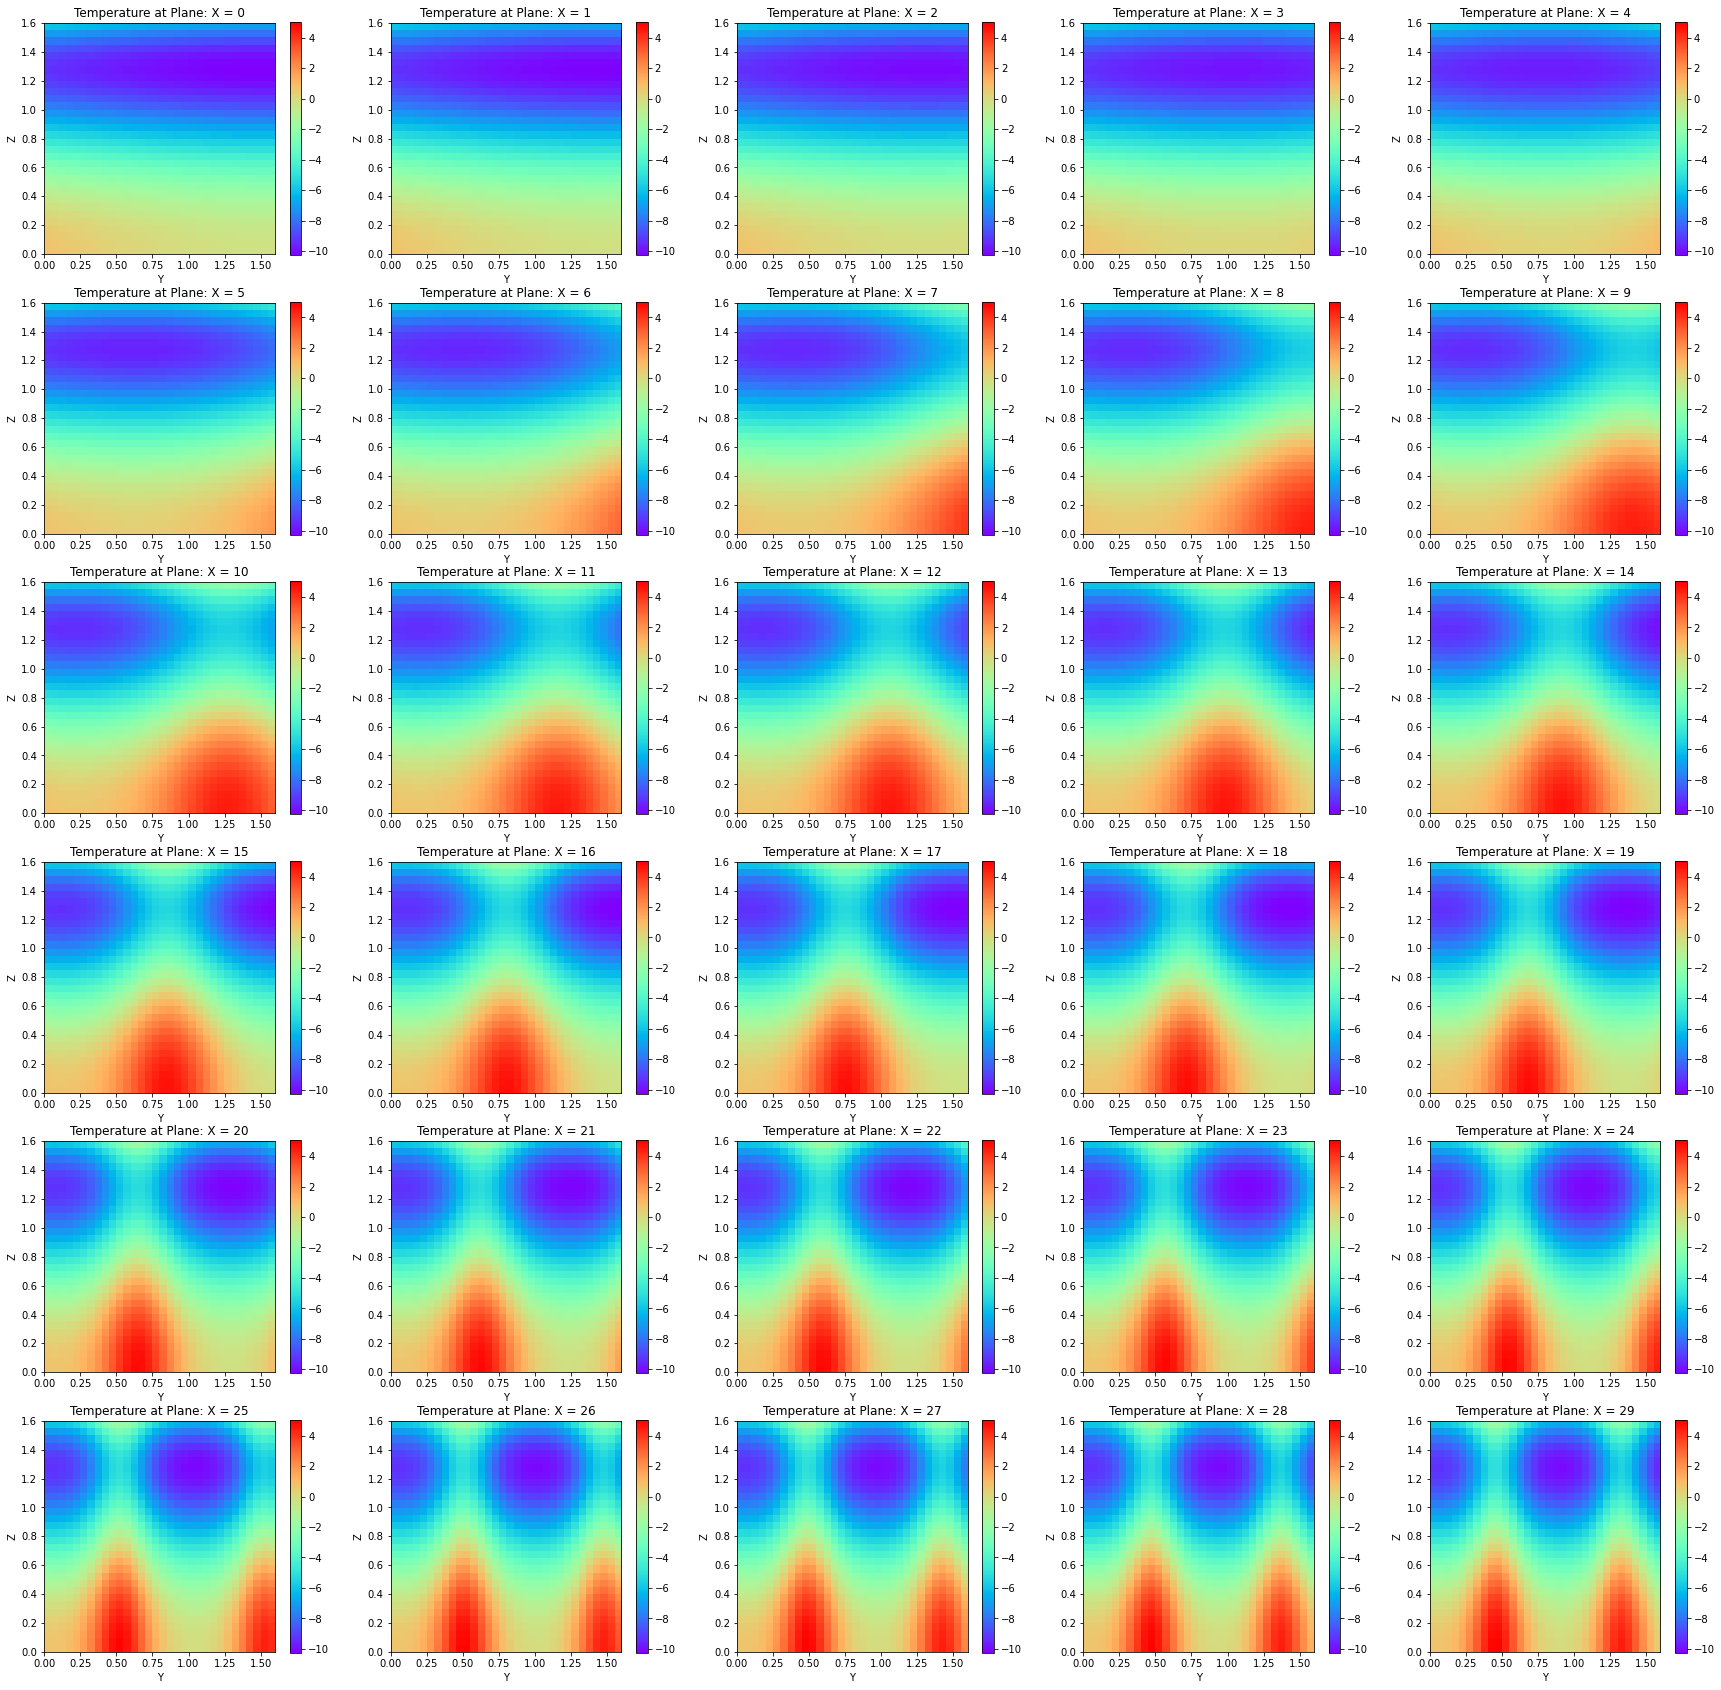

In [2]:
#grid spacing
dl=0.05

# function to assign initial temperature values to points on mesh
def initialT(x,y,z,dx):
    x *= dx
    y *= dx
    z *= dx
    return 2*np.exp(-1*np.cos(5*x*z)) - 10*np.sin(y**2) -np.sin(z)

# assigning mesh values for initial snapshot
state0 = np.zeros([32, 32, 32])
for x in range(np.shape(state0)[0]):
    for y in range(np.shape(state0)[1]):
        for z in range(np.shape(state0)[2]):
            state0[x][y][z] = initialT(x,y,z, dl)

# will plot a slice of the mesh of the temperature at a plane normal to the x-axis 
def plotxSlice(mesh, dl, x_slice, multiple=False):
    if multiple:     
        pos = plt.imshow(mesh[x_slice],vmin=np.min(mesh), vmax = np.max(mesh), 
                extent =[0, dl*np.shape(mesh[x_slice])[0], 0, dl*np.shape(mesh[x_slice])[1]],
                interpolation='nearest', cmap='rainbow', origin ='lower')
    else:
        pos = plt.imshow(mesh[x_slice],
                extent =[0, dl*np.shape(mesh[x_slice])[0], 0, dl*np.shape(mesh[x_slice])[1]],
                interpolation='nearest', cmap='rainbow', origin ='lower')
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title("Temperature at Plane: X = %s" % x_slice)
    plt.colorbar(pos)

# prints out various slices of our mesh to see the initial temperature distribution
plt.subplots(figsize=(30,30))
for i in range(0,30):
    plt.subplot(6,5,i+1)
    plotxSlice(state0, dl, i, multiple=True) 

### Defining a time-dependent non-uniform thermal diffusitivity
This ensures that our system will not collapse to a steady-state equilibria while also enabling more interesting dynamics.

**Note: In a practical application, we would have a grid with the values of thermal diffusitivity at all the points at various times. We just use a function in this case.**

In [39]:
# function describing thermal diffusitivity at any point on the mesh; spatiotemporal-dependence or uniform
def alpha(t,x,y,z, dl, TD=False):
    if TD: 
        x *= dl
        y *= dl
        z *= dl
        alpha = np.exp(-t*x*y) - np.cos(z**2) * np.sin(z)
    else: 
        alpha = 0.05
    return alpha

### Finite Difference Computations for Mesh

In [40]:
# finite difference for 2nd order central difference
def FD_2nd(vector, dl):
    vxx = [0]
    for i in range(np.shape(vector)[0]-2):
        vxx.append((vector[i+2]+vector[i]-2*vector[i+1])/(dl**2))
    vxx.append(0)
    return np.array(vxx)

#calculates FD 2nd partial derivatives for the mesh in each dimension
def uxx(mesh,dl):
    nx, ny, nz = np.shape(mesh)
    uxx = np.zeros([nx, ny, nz]) 
    for y in range(ny):
        for z in range(nz):
            vector = []
            for i in range(nx):
                vector.append(mesh[i][y][z])
            vector = np.array(vector)
            FD = FD_2nd(vector, dl)
            for x in range(nx): 
                uxx[x][y][z] = FD[x]
    return uxx

def uyy(mesh,dl):
    nx, ny, nz = np.shape(mesh)
    uyy = np.zeros([nx, ny, nz]) 
    for x in range(nx):
        for z in range(nz):
            vector = []
            for i in range(ny):
                vector.append(mesh[x][i][z])
            vector = np.array(vector)
            FD = FD_2nd(vector, dl)
            for y in range(ny): 
                uyy[x][y][z] = FD[y]
    return uyy
def uzz(mesh, dl):
    nx, ny, nz = np.shape(mesh)
    uzz = np.zeros([nx, ny, nz])
    for x in range(nx):
        for y in range(ny):
            uzz[x][y] = FD_2nd(mesh[x][y], dl)
    return uzz

def ut(t, mesh, nx, ny, nz, dl, TD=False):
    mesh = np.reshape(mesh, (nx, ny, nz))
    
    x = np.arange(nx).astype('f')
    x = np.repeat(x, ny*nz)
    y = np.arange(ny).astype('f')
    y = np.repeat(y, nx*nz)
    z = np.arange(nz).astype('f')
    z = np.repeat(z, nx*ny)
    
    if TD:
        ut = alpha(t, x, y, z, dl, TD).reshape((nx,ny,nz))*(uxx(mesh, dl)+uyy(mesh,dl)+uzz(mesh,dl))
    else: 
        ut = alpha(t, x, y, z, dl)*(uxx(mesh, dl)+uyy(mesh,dl)+uzz(mesh,dl))
    return np.reshape(ut, (-1))

### Example with a Uniform Material

In [46]:
st = time.time()
t_eval = np.arange(0,5, 0.01)
sol = solve_ivp(ut, t_span=(t_eval[0], t_eval[-1]), y0=np.reshape(state0, (-1)), t_eval=t_eval,args=(32, 32, 32, dl))
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

(32768, 500)


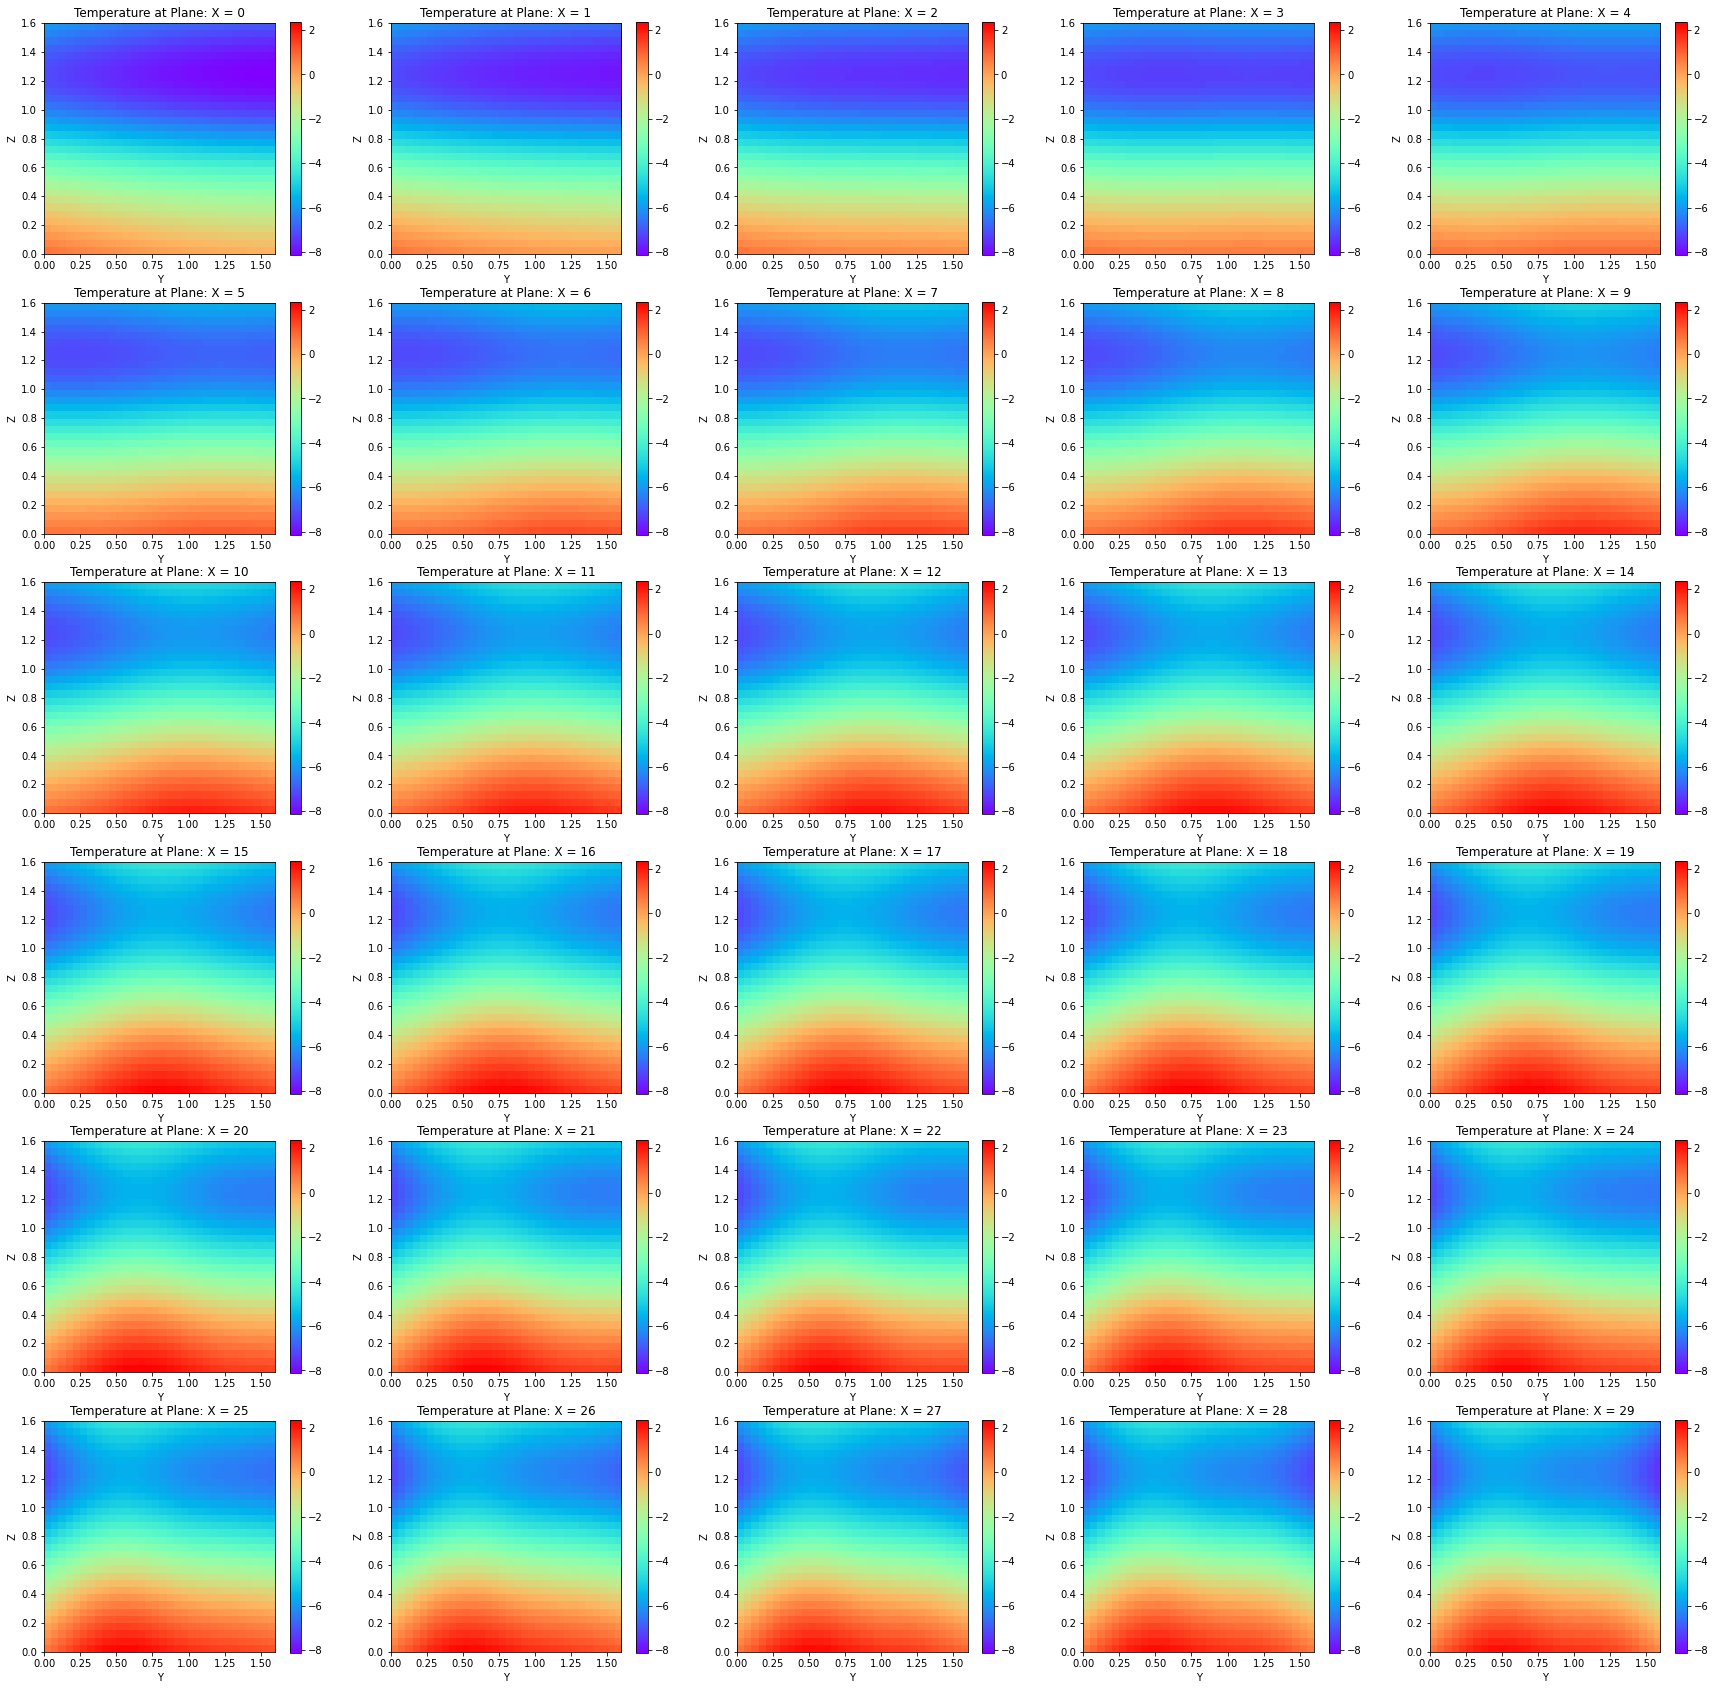

In [47]:
print(np.shape(sol.y))
plt.subplots(figsize=(30,30))
y = np.reshape(sol.y.T[99], (32,32,32))
for i in range(0,30):
    plt.subplot(6,5,i+1)
    plotxSlice(y, dl, i, multiple=True)

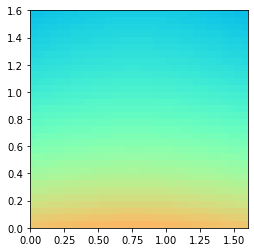

In [52]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
fig, ax = plt.subplots()
def animate(i):
    y = np.reshape(sol.y.T[i*5], (32,32,32))
    pos = plt.imshow(y[15],vmin=np.min(sol.y), vmax = np.max(sol.y), 
                extent =[0, dl*np.shape(y[15])[0], 0, dl*np.shape(y[15])[1]],
                interpolation='nearest', cmap='rainbow', origin ='lower')
ani = FuncAnimation(fig, animate, frames=100, interval=50, repeat=False)
HTML(ani.to_jshtml())